# SDC Project \#5: Vehicle Detection

## Part 1 Feature Extraction
### Here, I extract some of the features

### 1. HOG and Color features
Let's go ahead and visualise some of the HOG features to get started. We will later optimize the parameters while trainin the classifier.

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from skimage.feature import hog


# Convert opencv image to matplotlib image
def cv2mp(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def read_image(filename):
    img = cv2.imread(image)
    return mp(img/255)

['test6.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test2.jpg', 'test1.jpg']


/home/alper/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


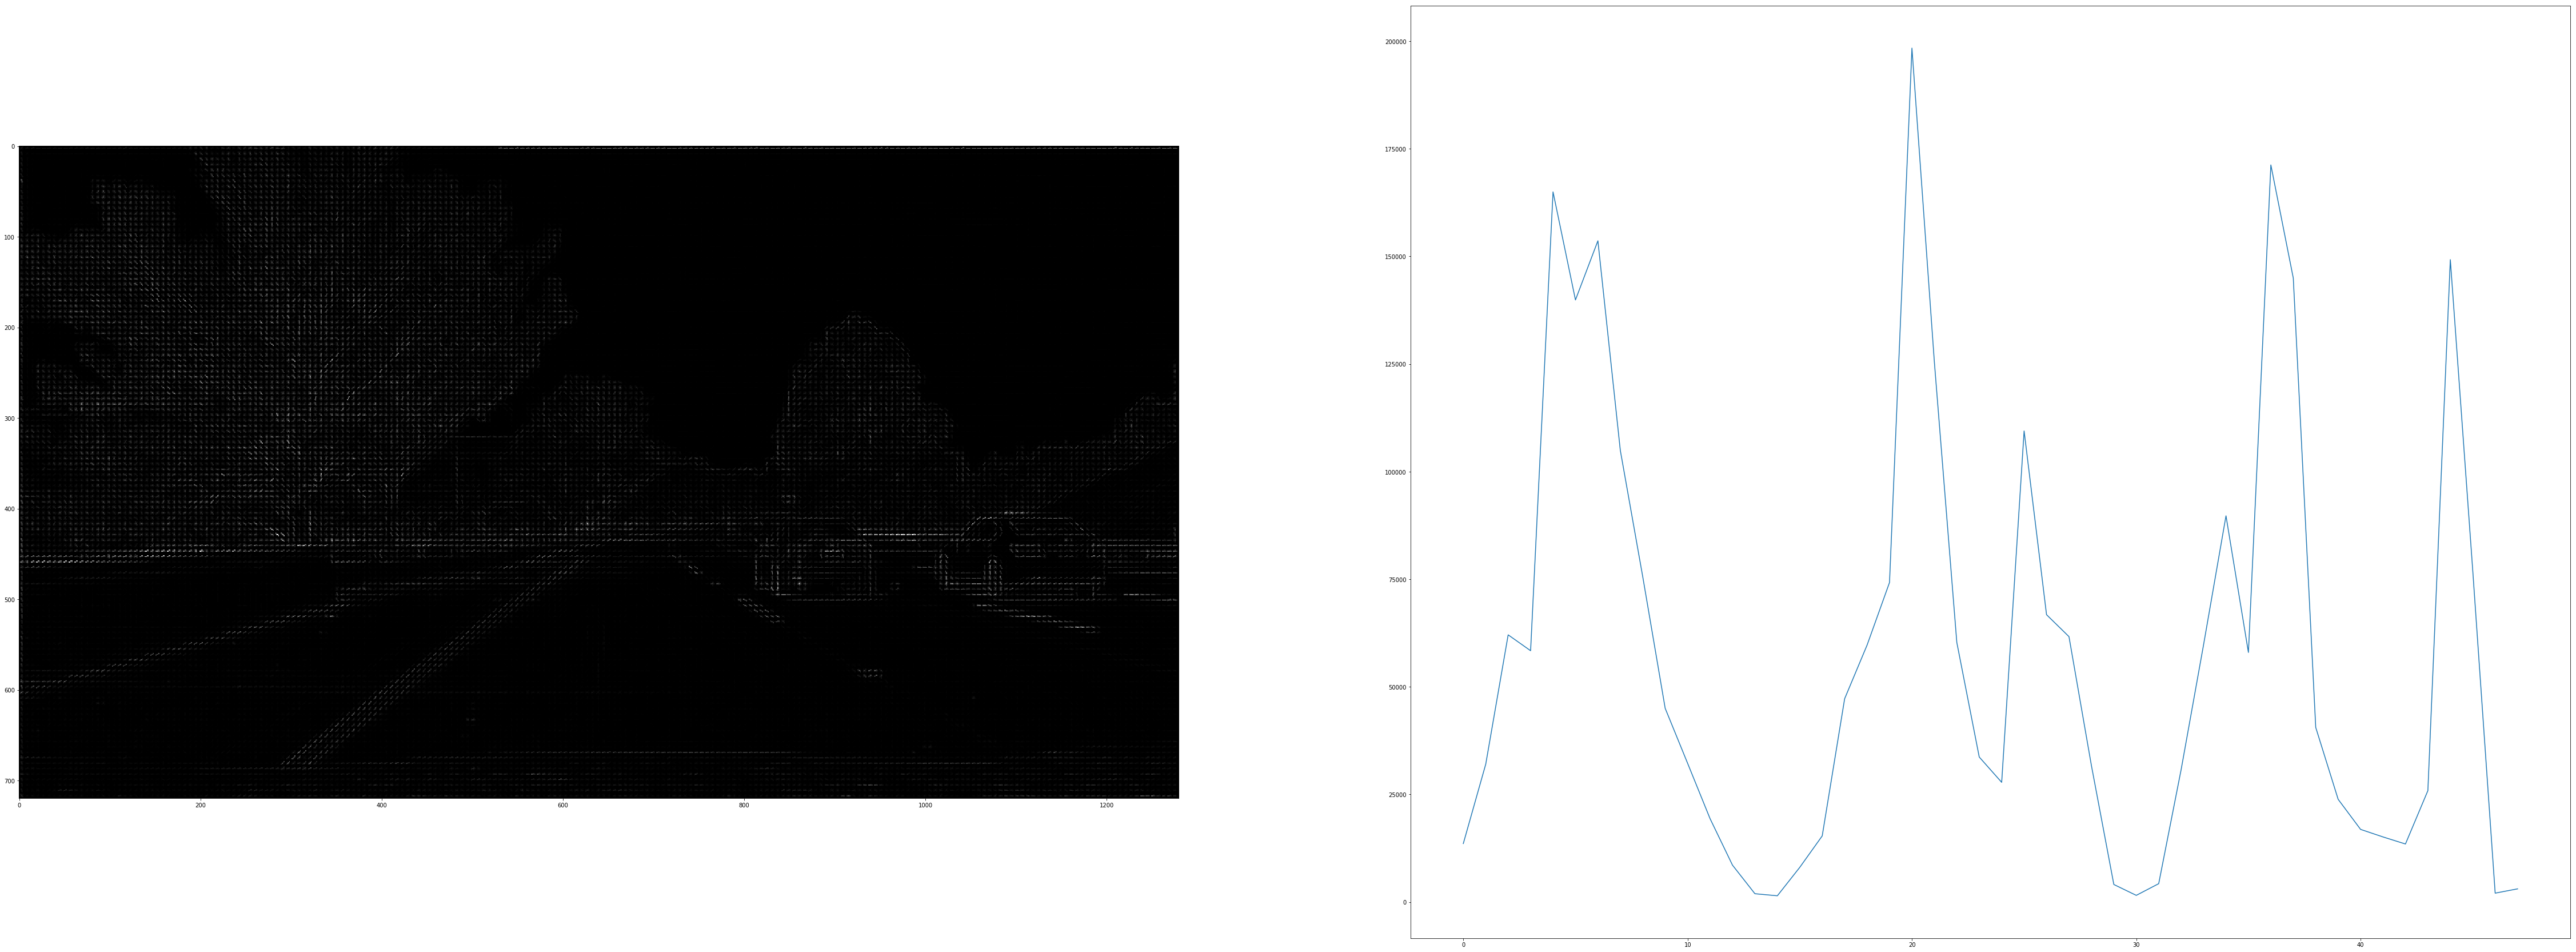

255
0


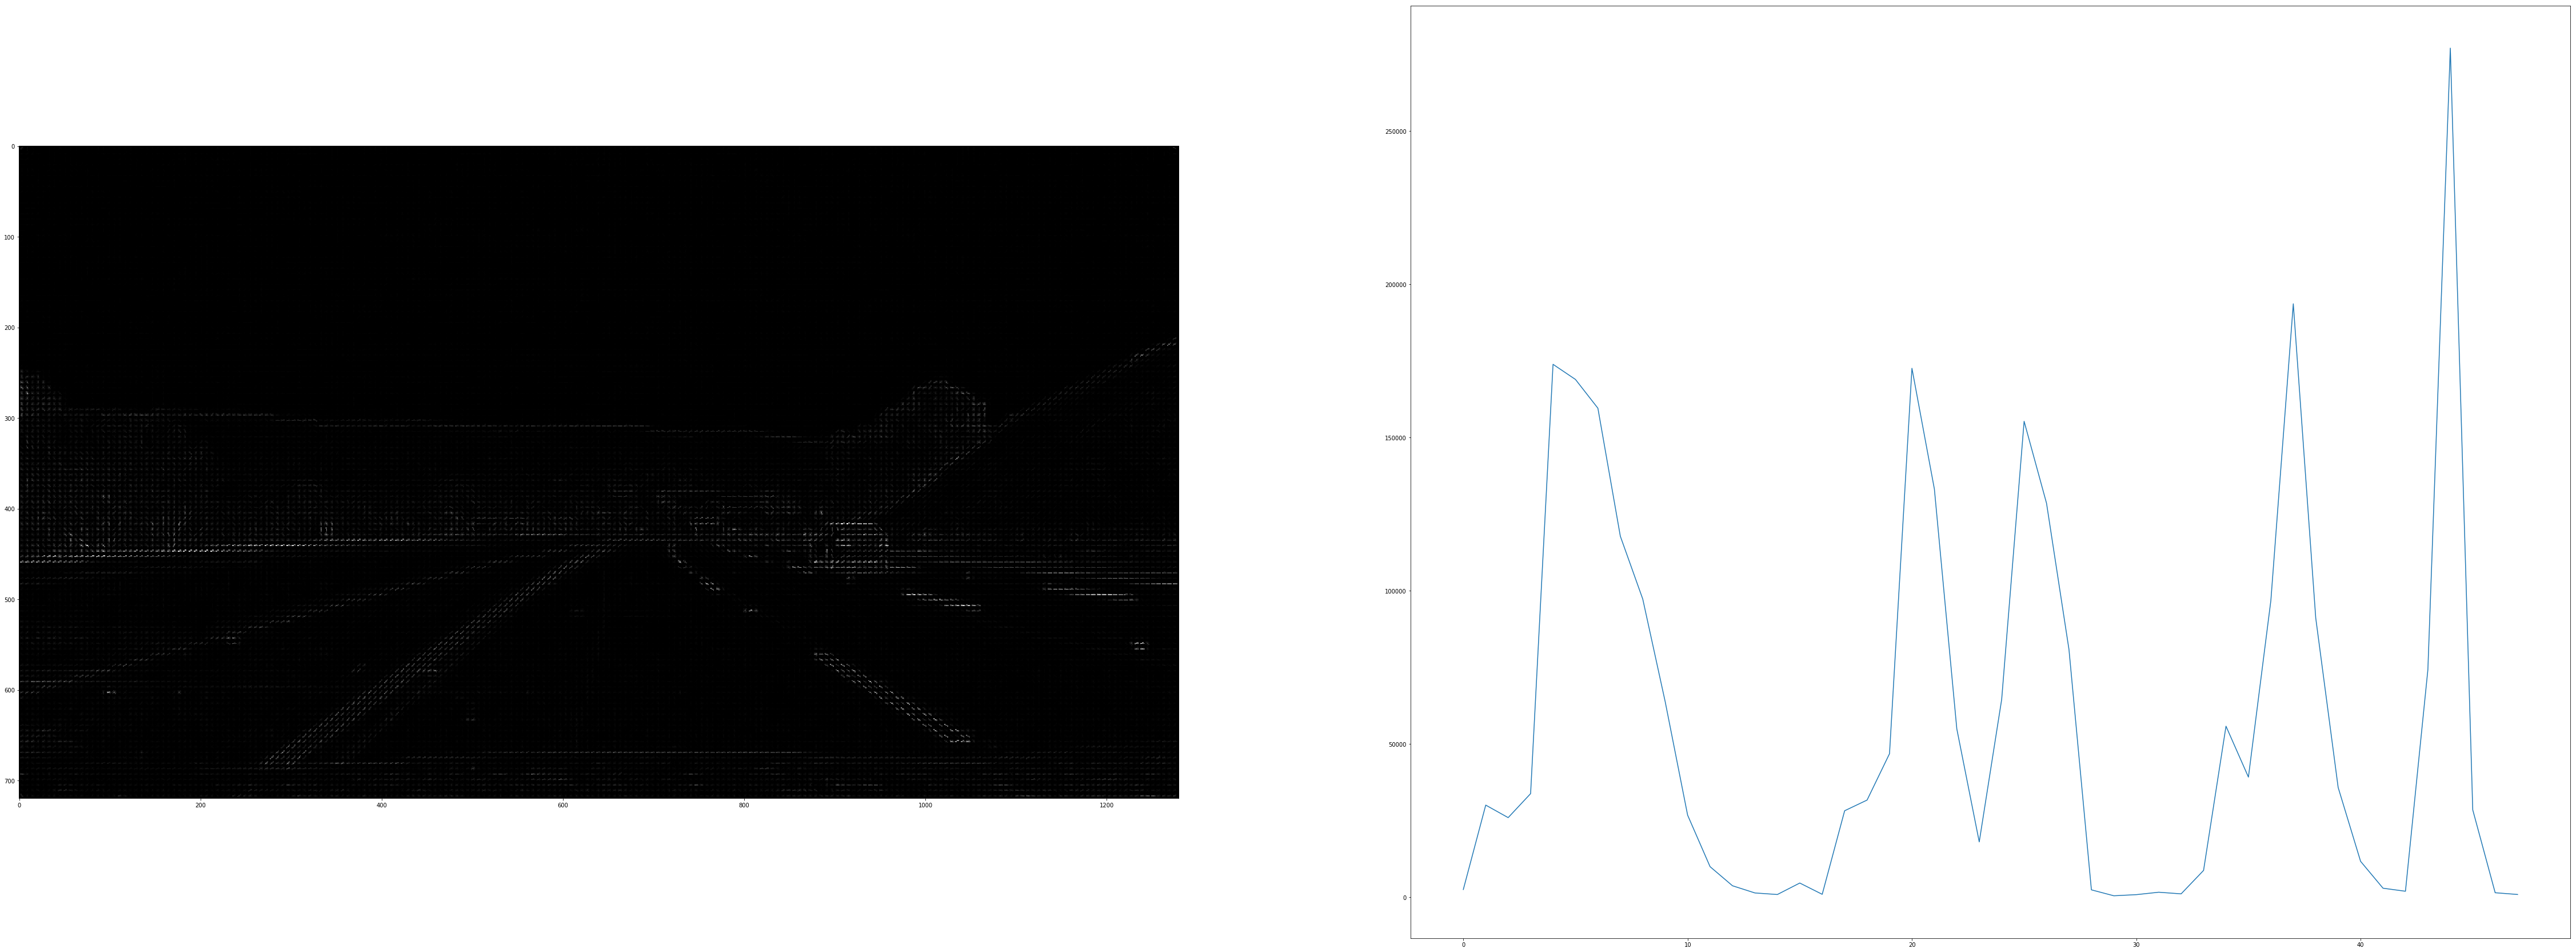

255
0


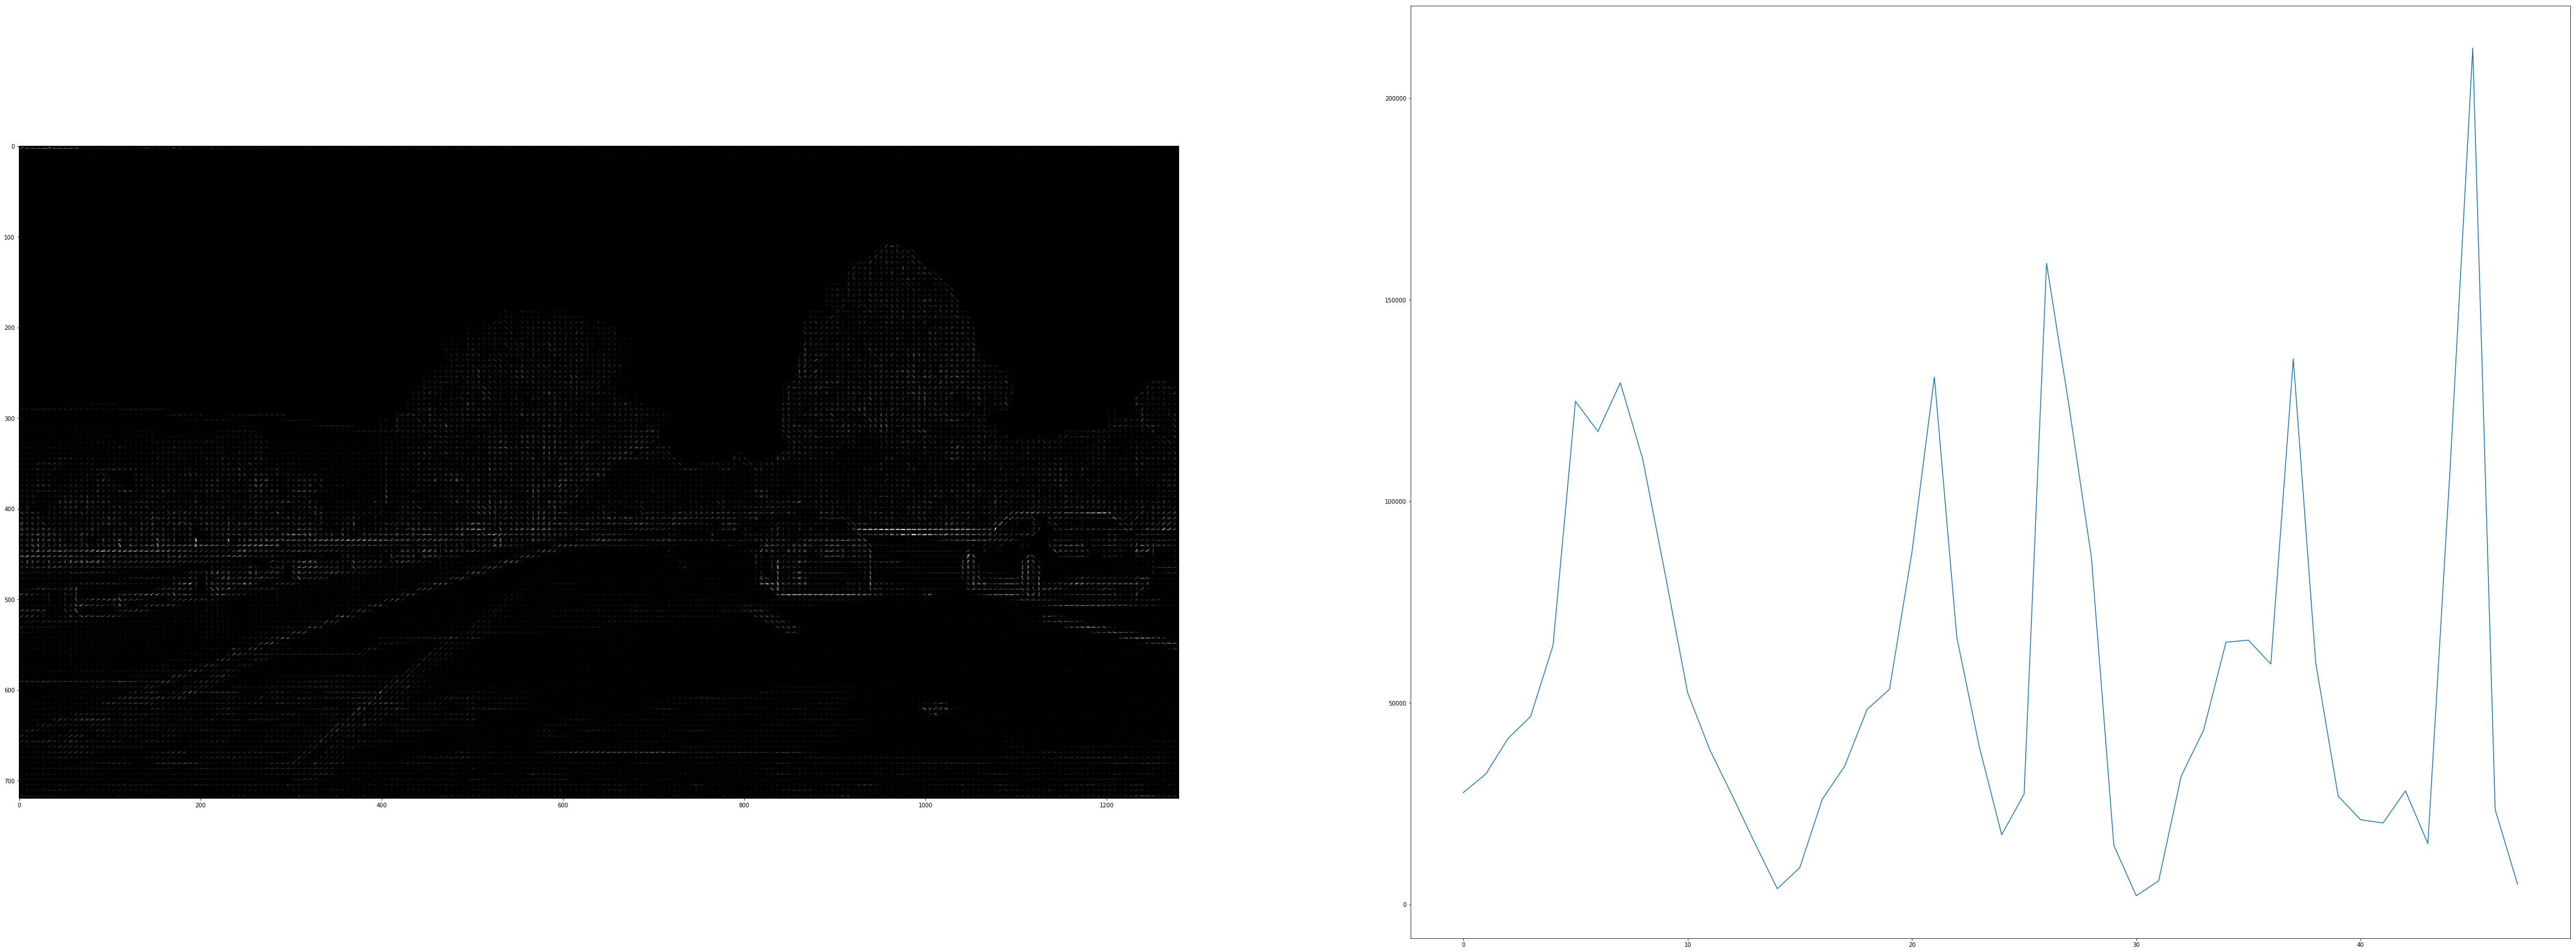

255
0


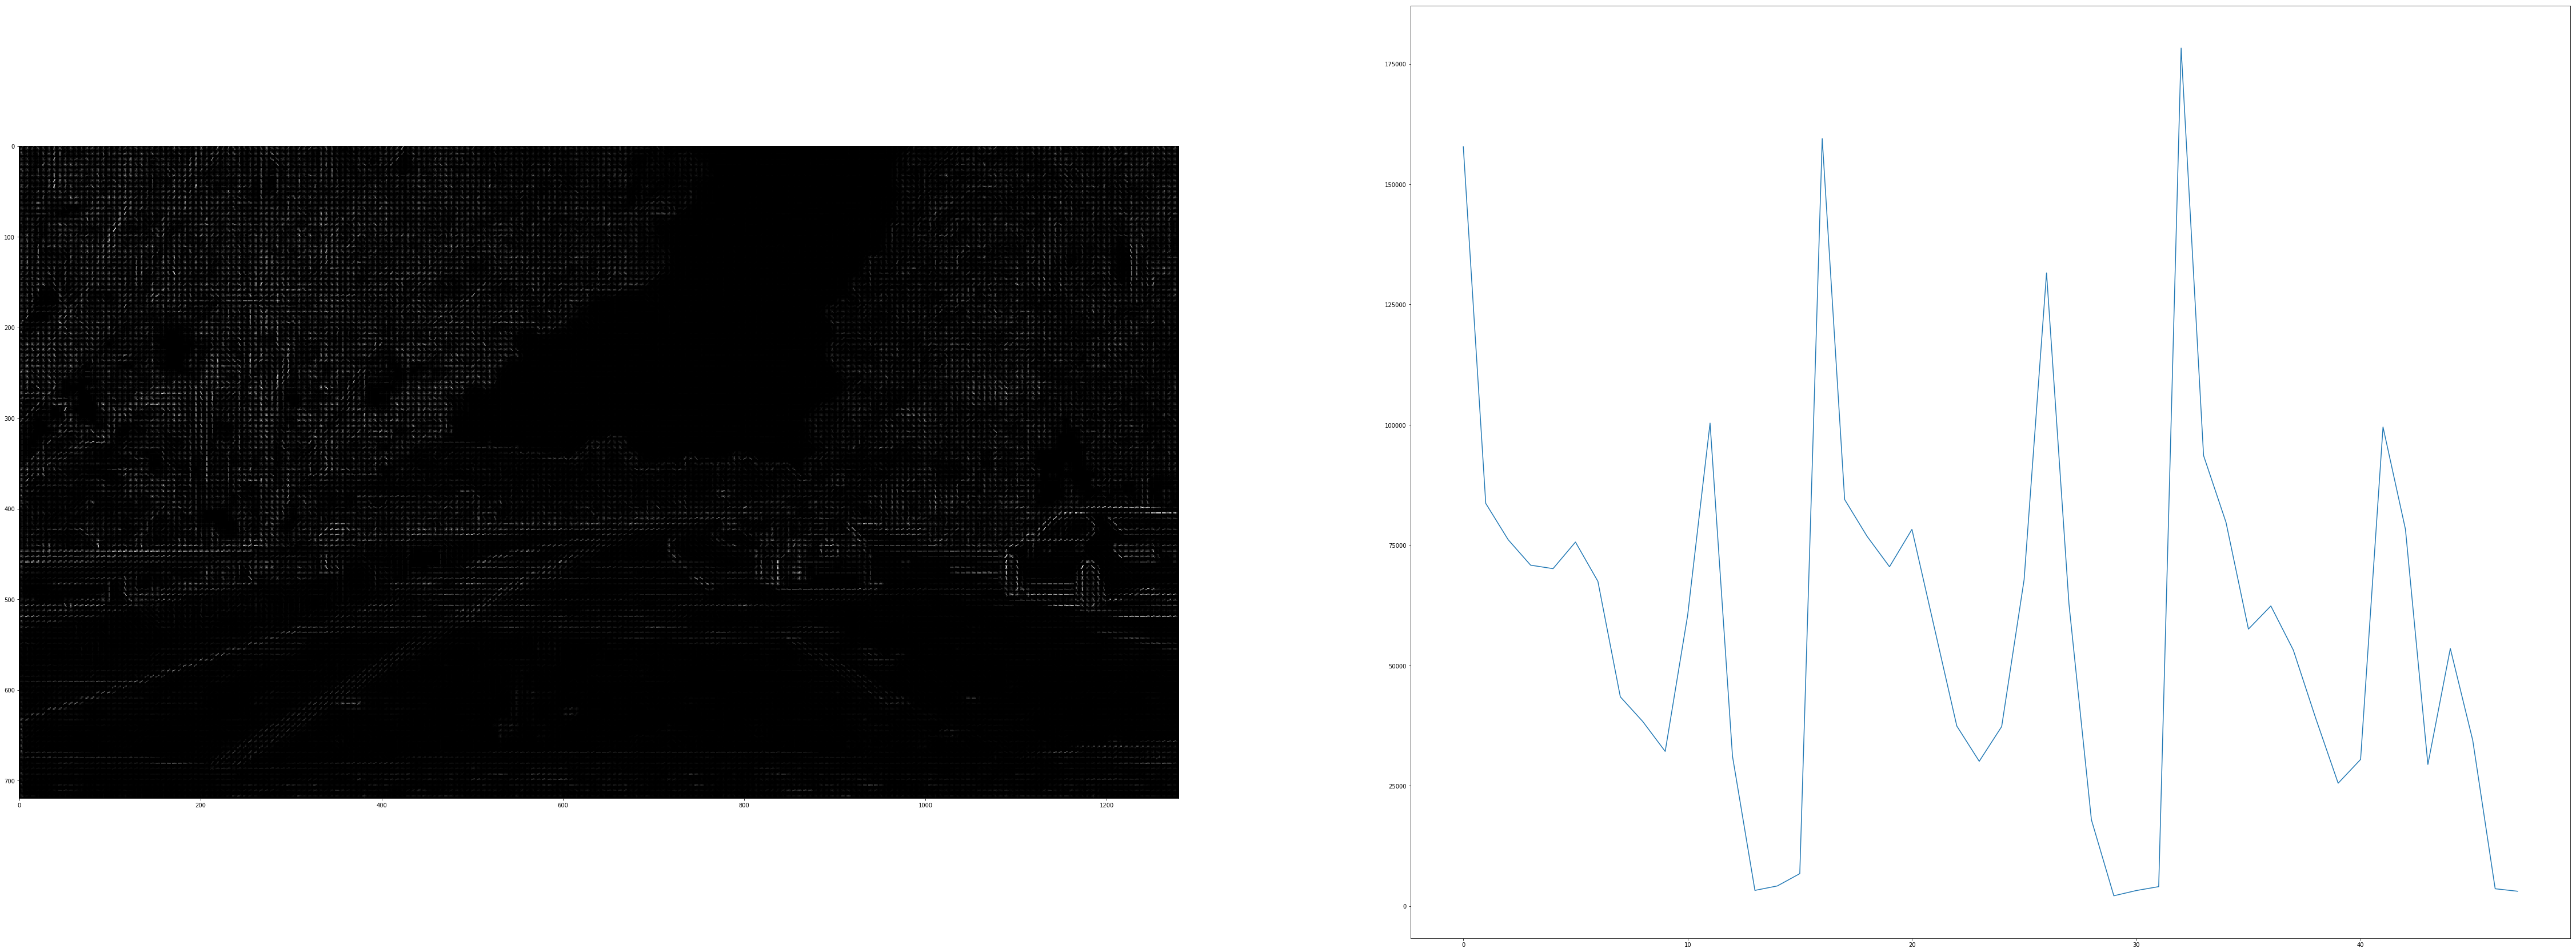

255
0


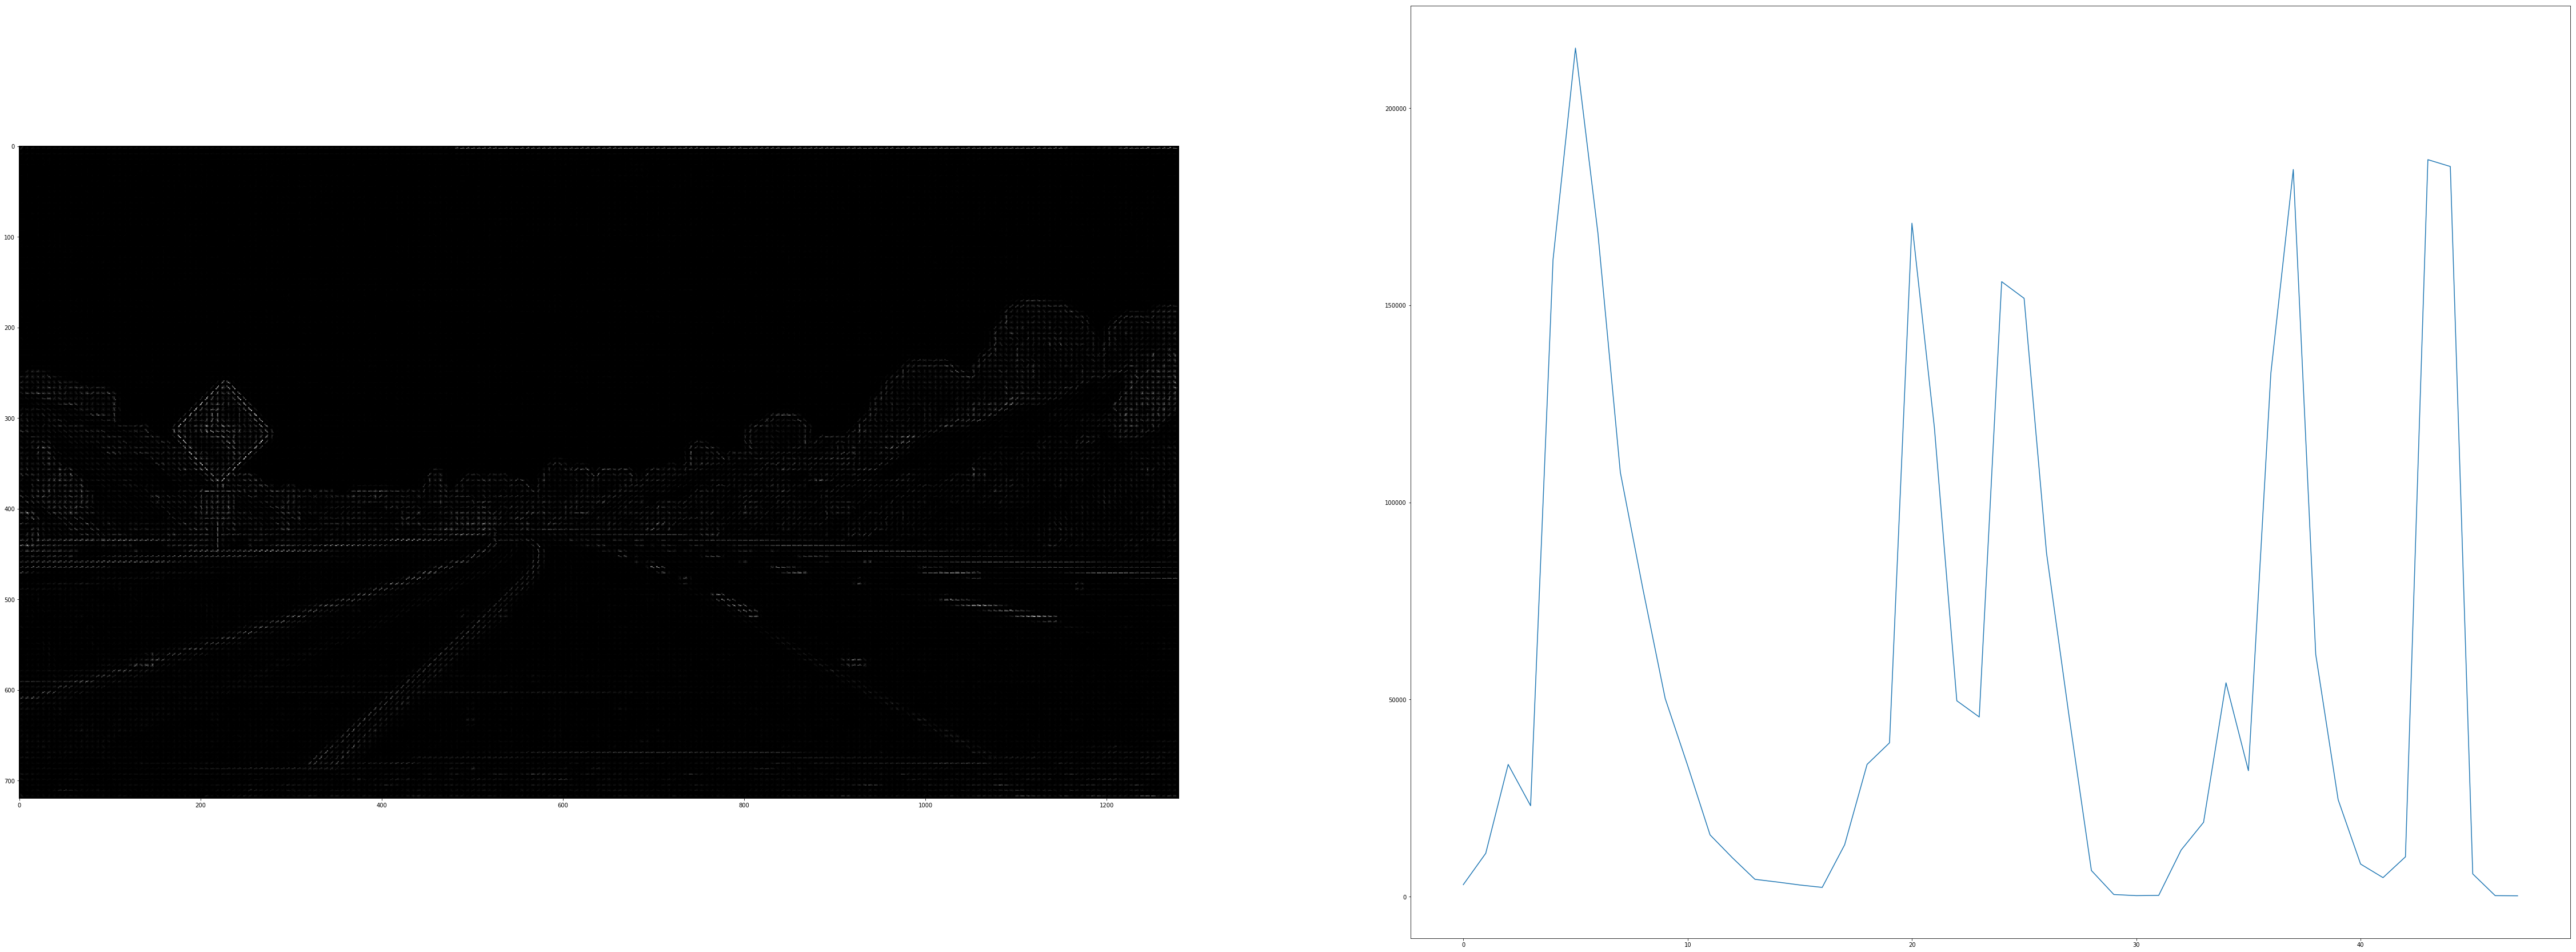

255
0


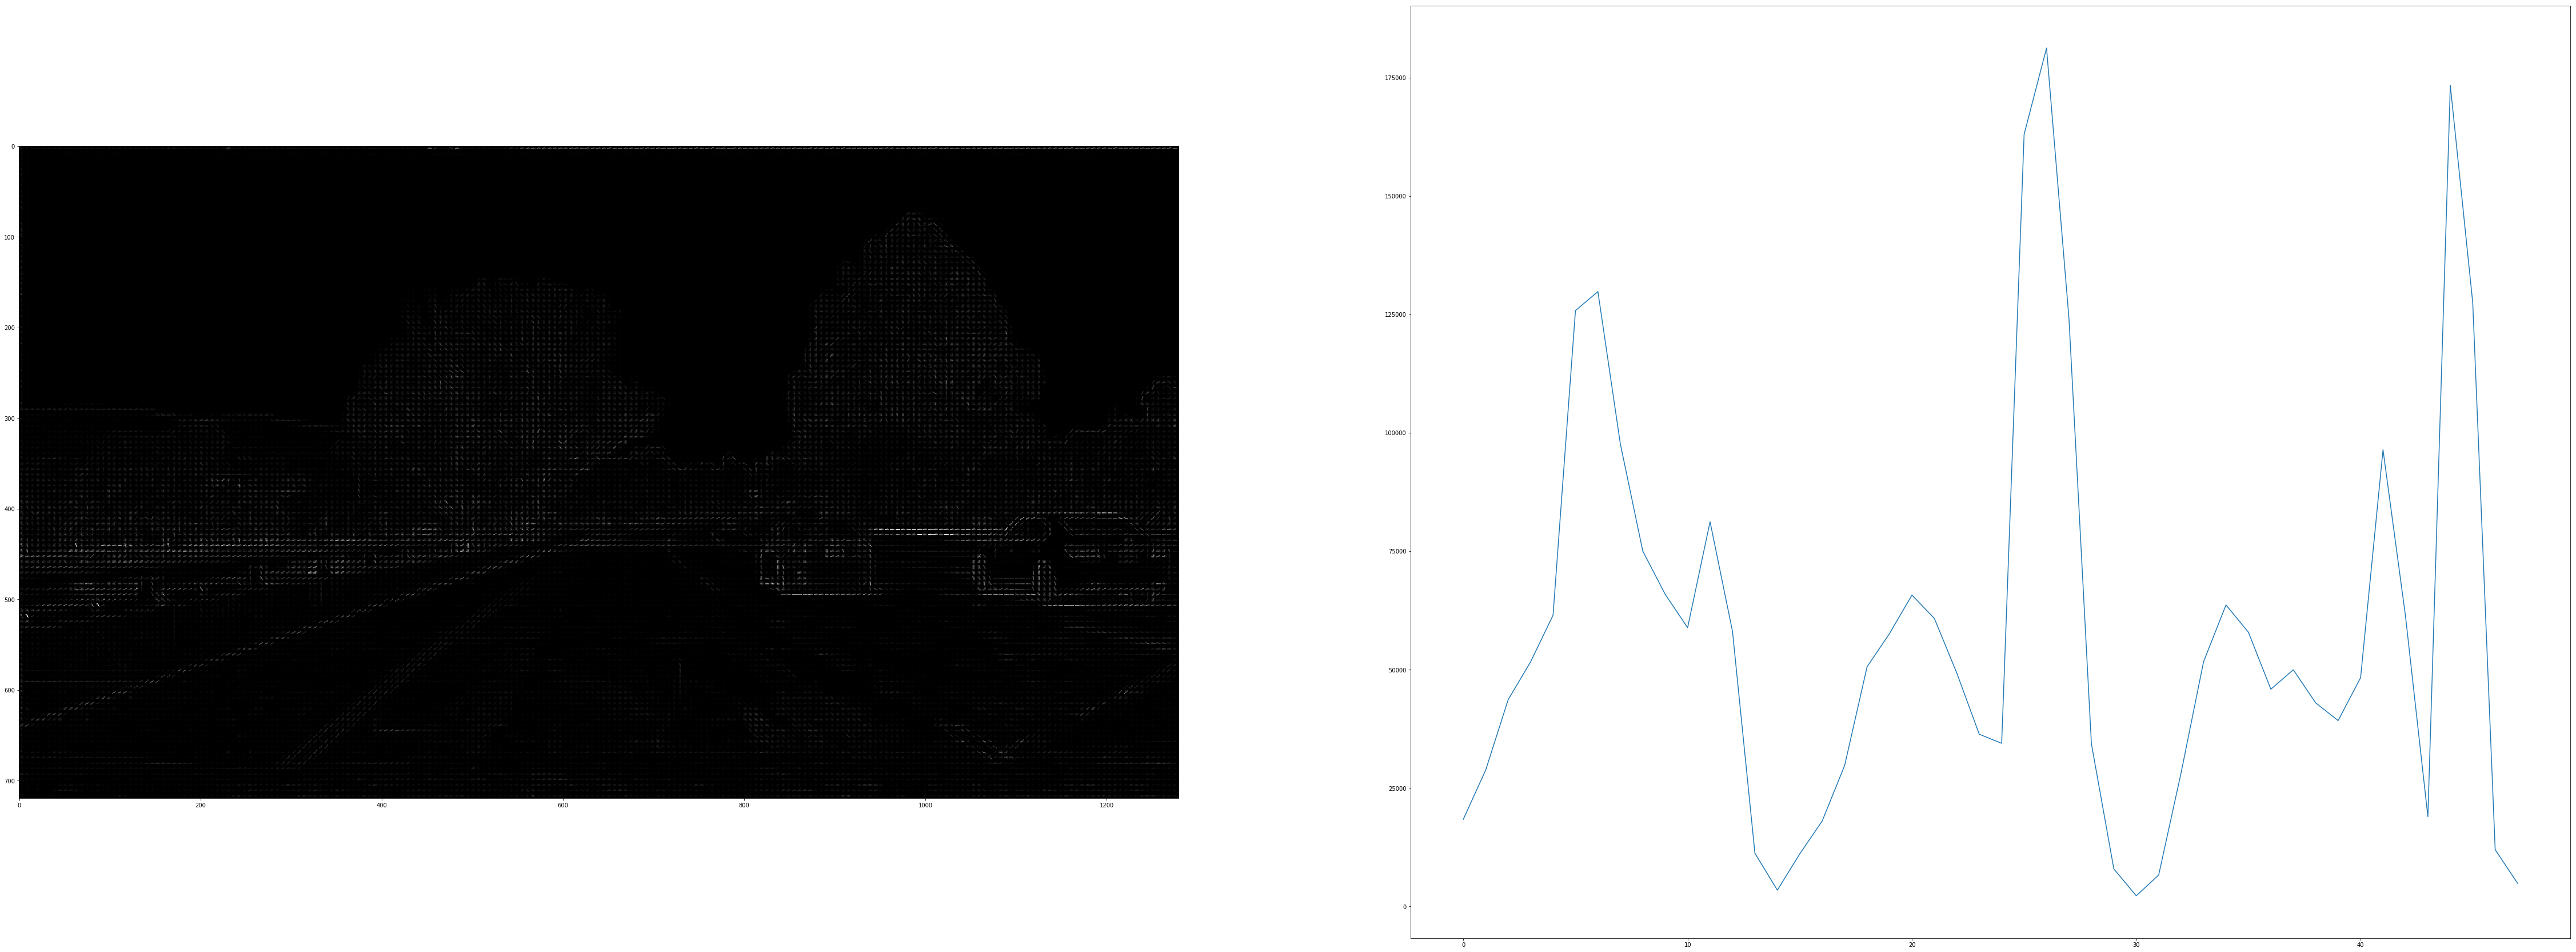

255
0


In [18]:
test_images = os.listdir("test_images")
print (test_images)

# parameters for HOG features
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 6
cell_per_block = 3
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# parameters for Color features
nbins=16
bins_range=(0, 256)

for image in test_images:
    # ignore non image files
    if image[0] is '.':
        continue
    
    file_name = "test_images/" + image 
    #print(file_name)
    #img = cv2.imread(file_name)
    img = mpimg.imread(file_name)
    # Use the grayscale for hog features
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    
    features, hog_image = hog(img[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=True)
    # use the BGR for color features
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
     
    
    fig = plt.figure(figsize=(80, 30)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(hog_image,cmap='gray')
    ax1.plot(hist_features)
    plt.show()
    
    print (img.max())
    print (img.min())


## Part 2 Training of Classifier

My classifier of choice is SVM because we have a large amount of data, that is enough to train a SVM classifier and we have a large amount of features. SVM can handle these situations. 
I will try and find the best parameters by training and testing the SVM classifier

In [3]:
#import necessary libraries
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


/home/alper/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First I'll import training data.

**Note for reviewers ** please unzip the 'vehicles.zip' and 'non-vehicles.zip' files in 'training_data' directory.

In [5]:
vehicles_dir = "training_data/vehicles"
non_vehicles_dir = "training_data/non-vehicles"
vehicle_files = []
non_vehicle_files = []

for v_dir in  os.listdir(vehicles_dir):
    if v_dir[0] is '.':
        continue
    for file in os.listdir(vehicles_dir + '/' + v_dir):
        if (file[0] is '.'):
            continue
        vehicle_files.append(vehicles_dir + '/' + v_dir + '/' + file)
        
for nv_dir in os.listdir(non_vehicles_dir):
    if nv_dir[0] is '.':
        continue
    for file in os.listdir(non_vehicles_dir + '/' + nv_dir):
        if (file[0] is '.'):
            continue
        non_vehicle_files.append(non_vehicles_dir + '/' + nv_dir + '/' + file)


vehicle_labels = np.ones(len(vehicle_files))
non_vehicle_labels = np.zeros(len(non_vehicle_files))
y = np.hstack((vehicle_labels, non_vehicle_labels))
# let's verify what we have discovered
print (len(vehicle_files))
print (vehicle_labels.shape)
print (len(non_vehicle_files))
print (y.shape)

8792
(8792,)
8968
(17760,)


For practicality I will use functions similar to the course material. I combined the HOG and Color extraction for feature extraction function.

In [47]:
def cvt_colorspace(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

            
            
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        feature_vec=True):
            
    vis=False  
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,  nbins=32, bins_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = cvt_colorspace(image, cspace)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        # Append the new feature vector to the features list
        hist_features = color_hist(feature_image, nbins=nbins, bins_range=bins_range)
        #hist_features = color_hist(image, nbins=nbins, bins_range=bins_range)
        #features.append(hog_features)
        features.append(np.concatenate((hog_features, hist_features)))
    # Return list of feature vectors
    return features



In [48]:
# parameters for HOG features
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16
pix_per_cell = 6
cell_per_block = 3
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# parameters for Color features
nbins=16
bins_range=(0, 255)

#train test split
rand_state = np.random.randint(0, 100)
split = 0.2

# extract the features
car_features = extract_features(vehicle_files, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,  nbins=nbins, bins_range=bins_range)
notcar_features = extract_features(non_vehicle_files, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,  nbins=nbins, bins_range=bins_range)



# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=split, random_state=rand_state)

/home/alper/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [49]:
# Train the classifier and validate

svc = LinearSVC()
svc.fit(X_train, y_train)

# Test the accuracy of the model
print('Test accuracy ', svc.score(X_test, y_test))

# save the model for future use
from sklearn.externals import joblib
#joblib.dump(svc, 'classifier.pkl') 

# We will later load it by
#clf = joblib.load('classifier.pkl') 

Test accuracy  0.986768018018


['classifier.pkl']


    # parameters for HOG features
    colorspace = 'LUV' 
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = 0

    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.968468468468

    # parameters for HOG features
    colorspace = 'HLS'
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = 1 
    
    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.966779279279

    # parameters for HOG features
    colorspace = 'YUV' 
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = "ALL"

    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.979448198198

    colorspace = 'HSV'
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = "ALL"

    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.991554054054
Test accuracy  0.986204954955


In [46]:
# Training takes a huge amount of memory, I will release it before continuing
import gc
del car_features
del notcar_features
gc.collect()

0

## Part 3 Sliding Window Search

### Search region

### Multi - Scale Search

### Heat Map


## Video Processing